# Stocks Sentiment Analysis using NLP with LSTM, GRU, and CNN models

 In today's dynamic financial landscape, understanding market sentiment has become paramount for making informed investment decisions. This project leverages the power of NLP to analyze and interpret textual data from tweets, providing insights into the sentiment surrounding stocks.  The goal of this project is to use NLP for stock sentiment analysis to decode the emotions behind stock market movements. By harnessing the power of advanced NLP techniques, this project aims to provide a reliable tool for investors to make more informed decisions.

In [104]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import plotly.express as px
import string
from imblearn.over_sampling import RandomOverSampler

# Tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional, Dropout, GlobalMaxPooling1D, GlobalMaxPooling2D, GRU, SpatialDropout1D, MaxPooling1D, concatenate, GlobalAveragePooling1D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam
import keras.backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import Data

This dataset from kaggle contains 5788 tweets that mention a stock and a labeled sentiment column.  The tweets are labeled negative (0) and positive (1).  The negative count is 2106 and the positive count is 3685.  

Chaudhary, Yash. (2020) Stock-Market Sentiment Dataset.  Kaggle.  https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset?datasetId=695933&sortBy=voteCount.  Accessed on : August 12, 2023.

In [3]:
stock_df = pd.read_csv("/content/drive/My Drive/28075442-stock-sentiment.csv")

In [4]:
stock_df

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1
...,...,...
5786,Industry body CII said #discoms are likely to ...,0
5787,"#Gold prices slip below Rs 46,000 as #investor...",0
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1


In [5]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


## EDA

In [6]:
# check for null values
stock_df.isnull().sum()

Text         0
Sentiment    0
dtype: int64

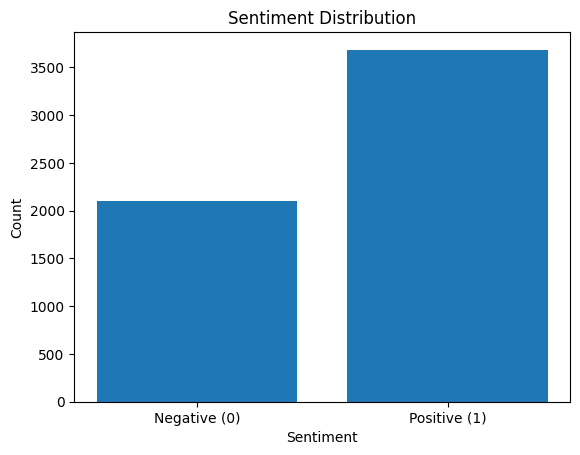

In [7]:
value_counts = stock_df['Sentiment'].value_counts()

# Create a bar plot using Matplotlib
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(value_counts.index, ['Positive (1)', 'Negative (0)'])
plt.title('Sentiment Distribution')
plt.show()

So we have an imbalanced dataset for the sentiments.

In [8]:
stock_df['Sentiment'].nunique()

2

### Data Cleaning

Remove punctuations from text

In [9]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
Test = '$I love my dog :)!!!'
Test_punc_removed = [char for char in Test if char not in string.punctuation]
Test_punc_removed

['I', ' ', 'l', 'o', 'v', 'e', ' ', 'm', 'y', ' ', 'd', 'o', 'g', ' ']

In [11]:
Test_punc_removed_join = ''.join(Test_punc_removed)
Test_punc_removed_join

'I love my dog '

In [12]:
# Let's define a function to remove punctuations
def remove_punc(message):
  Test_punc_removed = [char for char in message if char not in string.punctuation]
  Test_punc_removed_join = ''.join(Test_punc_removed)
  return Test_punc_removed_join

In [13]:
# Let's remove punctuations from our dataset
stock_df['Text Without Punctuation'] = stock_df['Text'].apply(remove_punc)

In [14]:
stock_df

,Text,Sentiment,Text Without Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...
3,MNTA Over 12.00,1,MNTA Over 1200
4,OI Over 21.37,1,OI Over 2137
...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...


Remove stopwords

In [15]:
# download stopwords
nltk.download("stopwords")
stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [16]:
# Obtain additional stopwords from nltk
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','will','aap','co','day','user','stock','today','week','year', 'https'])

In [17]:
# Remove stopwords and remove short words (less than 2 characters)
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if len(token) >= 2 and token not in stop_words:
            result.append(token)

    return result

In [18]:
# apply pre-processing to the text column
stock_df['Text Without Punc & Stopwords'] = stock_df['Text Without Punctuation'].apply(preprocess)

In [19]:
stock_df['Text'][0]

'Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts'

In [20]:
stock_df['Text Without Punc & Stopwords'][0]

['kickers',
 'watchlist',
 'xide',
 'tit',
 'soq',
 'pnk',
 'cpw',
 'bpz',
 'aj',
 'trade',
 'method',
 'method',
 'see',
 'prev',
 'posts']

### Wordcloud

In [21]:
# join the words into a string
stock_df['Text Without Punc & Stopwords Joined'] = stock_df['Text Without Punc & Stopwords'].apply(lambda x: " ".join(x))

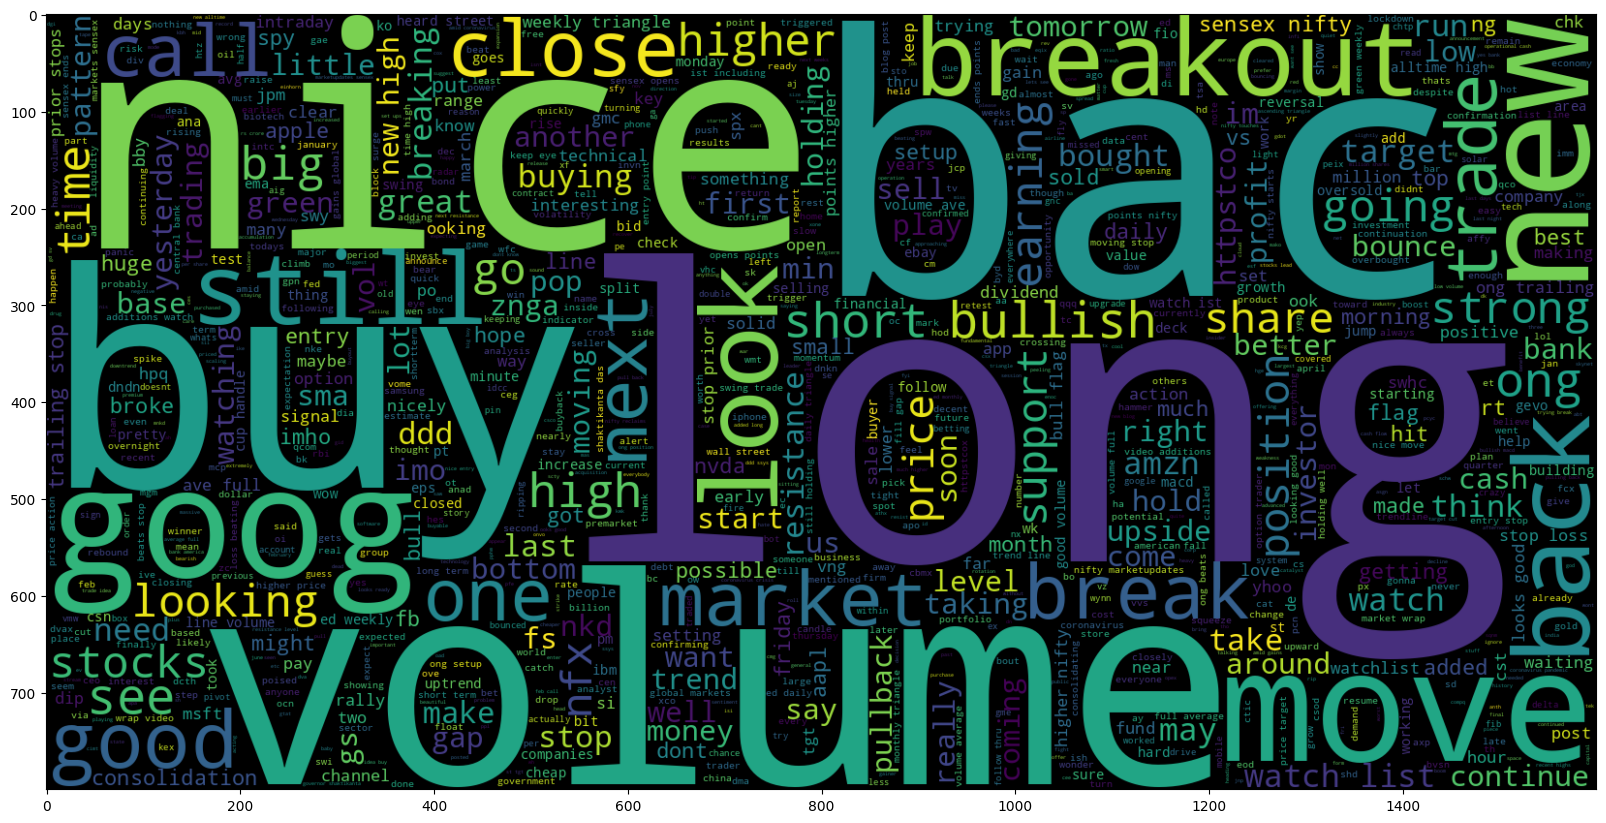

In [22]:
# plot the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

We see some words in the positive tweets that shouldn't be too surprising like long, buy, nice, call, and breakout

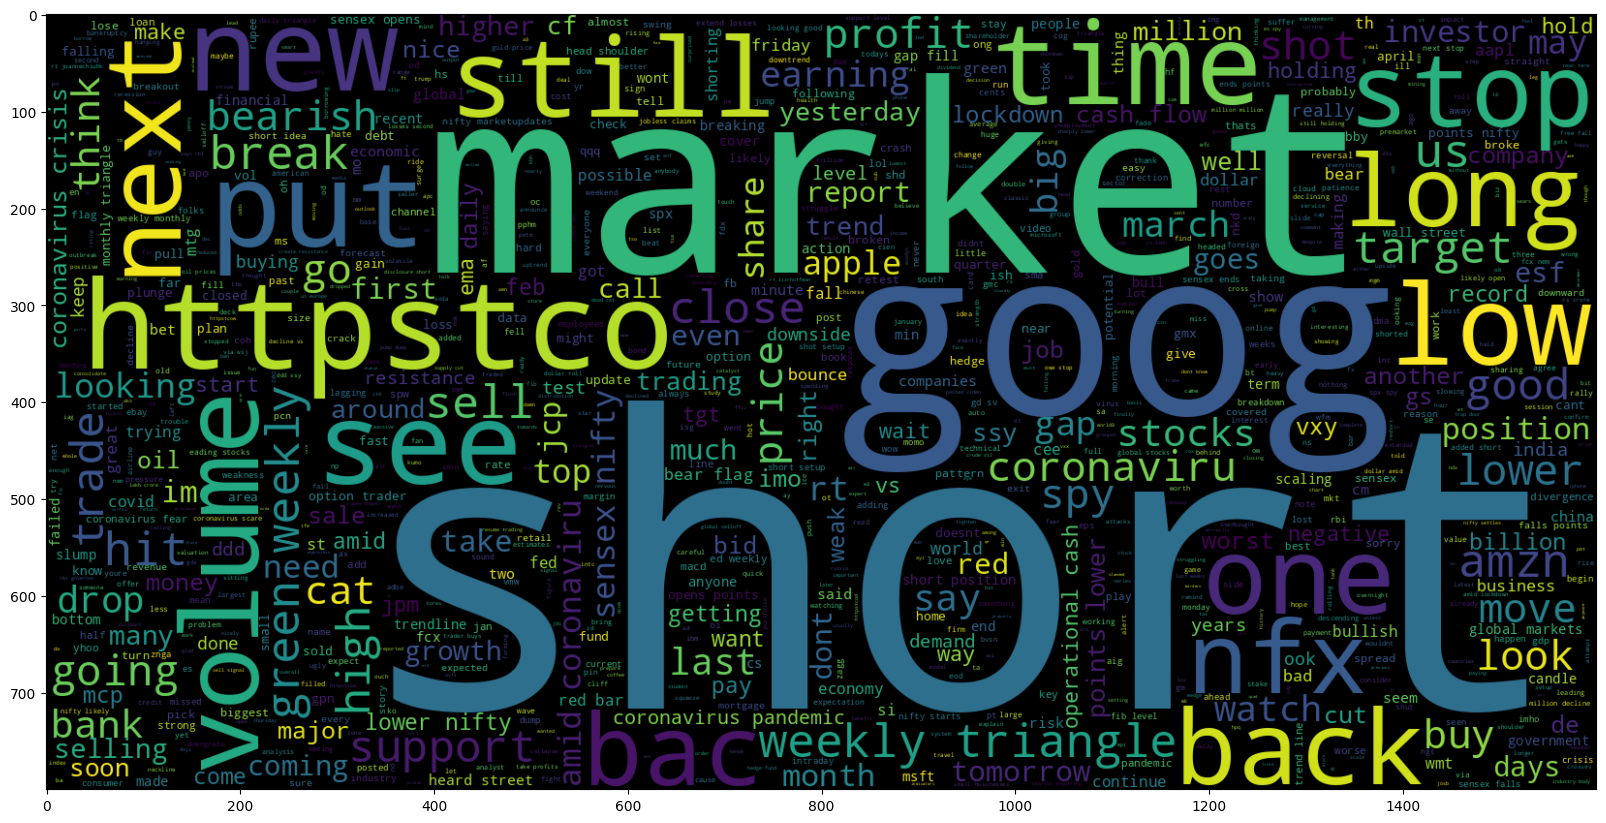

In [23]:
# plot the word cloud for text with positive sentiment
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800).generate(" ".join(stock_df[stock_df['Sentiment'] == 0]['Text Without Punc & Stopwords Joined']))
plt.imshow(wc, interpolation = 'bilinear');

Again for the negative sentiment tweets we see some words we should expect like short, low, bearish, and sell.

### Visualize Cleaned Data

In [24]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[oi],oi
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, rs, investors, book, prof...",gold prices slip rs investors book profits ami...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [25]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [26]:
# word_tokenize is used to break up a string into words
print(stock_df['Text Without Punc & Stopwords Joined'][0])
print(nltk.word_tokenize(stock_df['Text Without Punc & Stopwords Joined'][0]))

kickers watchlist xide tit soq pnk cpw bpz aj trade method method see prev posts
['kickers', 'watchlist', 'xide', 'tit', 'soq', 'pnk', 'cpw', 'bpz', 'aj', 'trade', 'method', 'method', 'see', 'prev', 'posts']


We want to find the maximum length because we will need it when we train our model.

In [27]:
# Obtain the maximum length of data in the document
# This will be later used when word embeddings are generated
maxlen = -1
for doc in stock_df['Text Without Punc & Stopwords Joined']:
    tokens = nltk.word_tokenize(doc)
    if(maxlen < len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is:", maxlen)

The maximum number of words in any document is: 22


In [28]:
tweets_length = [ len(nltk.word_tokenize(x)) for x in stock_df['Text Without Punc & Stopwords Joined'] ]

In [29]:
# Plot the distribution for the number of words in a text
fig = px.histogram(x = tweets_length, nbins = 50)
fig.show()

In [30]:
tweets_length_pos = [ len(nltk.word_tokenize(x)) for x in stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']]

In [31]:
# Plot the distribution for the number of words in a positive tweet
fig = px.histogram(x = tweets_length_pos, nbins = 50)
fig.show()

In [32]:
tweets_length_neg = [ len(nltk.word_tokenize(x)) for x in stock_df[stock_df['Sentiment'] == 1]['Text Without Punc & Stopwords Joined']]

In [33]:
# Plot the distribution for the number of words in a negative tweet
fig = px.histogram(x = tweets_length_neg, nbins = 50)
fig.show()

### Prepare the Data by Tokenizing and Padding

In [34]:
stock_df

,Text,Sentiment,Text Without Punctuation,Text Without Punc & Stopwords,Text Without Punc & Stopwords Joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user AAP MOVIE 55 return for the FEAGEED indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user Id be afraid to short AMZN they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...
3,MNTA Over 12.00,1,MNTA Over 1200,[mnta],mnta
4,OI Over 21.37,1,OI Over 2137,[oi],oi
...,...,...,...,...,...
5786,Industry body CII said #discoms are likely to ...,0,Industry body CII said discoms are likely to s...,"[industry, body, cii, said, discoms, likely, s...",industry body cii said discoms likely suffer n...
5787,"#Gold prices slip below Rs 46,000 as #investor...",0,Gold prices slip below Rs 46000 as investors b...,"[gold, prices, slip, rs, investors, book, prof...",gold prices slip rs investors book profits ami...
5788,Workers at Bajaj Auto have agreed to a 10% wag...,1,Workers at Bajaj Auto have agreed to a 10 wage...,"[workers, bajaj, auto, agreed, wage, cut, peri...",workers bajaj auto agreed wage cut period apri...
5789,"#Sharemarket LIVE: Sensex off day’s high, up 6...",1,Sharemarket LIVE Sensex off day’s high up 600 ...,"[sharemarket, live, sensex, high, points, nift...",sharemarket live sensex high points nifty test...


In [35]:
# Obtain the total words present in the dataset
list_of_words = []
for i in stock_df['Text Without Punc & Stopwords']:
    for j in i:
        list_of_words.append(j)

In [36]:
# Obtain the total number of unique words
total_words = len(list(set(list_of_words)))
total_words

9647

In [37]:
# split the data into test and train
X = stock_df['Text Without Punc & Stopwords']
y = stock_df['Sentiment']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [38]:
X_train.shape, X_test.shape

((4632,), (1159,))

In [39]:
y_train.shape, y_test.shape

((4632,), (1159,))

Let's balance the dataset by oversampling the negative sentiment tweets.  While oversampling can introduce redundancy, it is often a valuable approach to address class imbalance and improve model performance.

In [40]:
oversampler = RandomOverSampler(random_state=42)
X_train_array = np.array(X_train).reshape(-1, 1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train_array, y_train)

In [41]:
X_train_resampled = X_train_resampled.ravel()
y_train_resampled = y_train_resampled.ravel()

In [42]:
X_train_resampled.shape, y_train_resampled.shape
y_train_resampled

array([0, 1, 1, ..., 0, 0, 0])

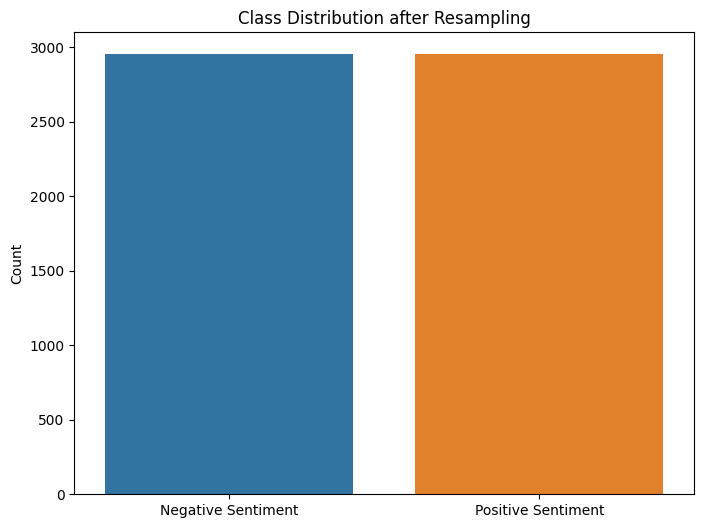

In [43]:
class_counts = np.bincount(y_train_resampled)

class_labels = ['Negative Sentiment', 'Positive Sentiment']

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Class Distribution after Resampling')
plt.ylabel('Count')
plt.show()

Looks balanced now.

In [44]:
# Create a tokenizer to tokenize the words and create sequences of tokenized words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(X_train_resampled)

# Training data
train_sequences = tokenizer.texts_to_sequences(X_train_resampled)

# Testing data
test_sequences = tokenizer.texts_to_sequences(X_test)

Let's take a look at a sample of some words and their tokens.

In [45]:
print("The encoding for document\n", X_train_resampled[1:2],"\n is: ", train_sequences[1])

The encoding for document
 [list(['nts', 'another', 'one', 'looks', 'strong', 'right', 'buy', 'tgt'])] 
 is:  [3174, 101, 27, 60, 77, 111, 25, 167]


Now let's pad the shorter data so that they all have the same length.

In [46]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequences, maxlen = 29, padding = 'post', truncating = 'post')
padded_test = pad_sequences(test_sequences, maxlen = 29, truncating = 'post')

We can see that the padding was successful.

In [47]:
for i, doc in enumerate(padded_train[:3]):
     print("The padded encoding for document:", i+1," is:", doc)

The padded encoding for document: 1  is: [1937  809  881  530    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 2  is: [3174  101   27   60   77  111   25  167    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
The padded encoding for document: 3  is: [ 641  882 4661  406 4662  810   52  883  740 3175  498 4663 3176 4664
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


Next let's convert y_train and y_test to 2D catagorical data for training.

In [48]:
# Convert the data to categorical 2D representation
y_train_cat = to_categorical(y_train_resampled, 2)
y_test_cat = to_categorical(y_test, 2)

In [49]:
y_train_cat.shape, y_test_cat.shape

((5904, 2), (1159, 2))

## Modeling

First we will start with a relatively simple LSTM RNN model.  After the embedding layer is a single LSTM layer followed by a global max poling layer then 2 dense layers with a dropout in between.

In [50]:
i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim = 512)(i)
x = SpatialDropout1D(0.3)(x)
x = LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model = Model(i, x)

In [51]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
rnn1 = model.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size = 64,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
93/93 [==============================] - 25s 193ms/step - loss: 0.6932 - accuracy: 0.5105 - val_loss: 0.6908 - val_accuracy: 0.6385
Epoch 2/10
93/93 [==============================] - 20s 210ms/step - loss: 0.6911 - accuracy: 0.5383 - val_loss: 0.6916 - val_accuracy: 0.6255
Epoch 3/10
93/93 [==============================] - 16s 173ms/step - loss: 0.6763 - accuracy: 0.6472 - val_loss: 0.6458 - val_accuracy: 0.6385
Epoch 4/10
93/93 [==============================] - 18s 192ms/step - loss: 0.4849 - accuracy: 0.7907 - val_loss: 0.7118 - val_accuracy: 0.6324
Epoch 5/10
93/93 [==============================] - 16s 177ms/step - loss: 0.3664 - accuracy: 0.8487 - val_loss: 0.7399 - val_accuracy: 0.6333
Epoch 6/10
93/93 [==============================] - 18s 193ms/step - loss: 0.3005 - accuracy: 0.8865 - val_loss: 0.6262 - val_accuracy: 0.6661
Epoch 7/10
93/93 [==============================] - 18s 195ms/step - loss: 0.2435 - accuracy: 0.9096 - val_loss: 0.6713 - va

It appears that the model's performance on both training and validation data is improving over the epochs. The loss values are decreasing, and the accuracy values are increasing, which are positive signs of learning. However, there might be some overfitting occurring, as the validation accuracy seems to plateau or slightly decrease after a few epochs.

<function matplotlib.pyplot.legend(*args, **kwargs)>

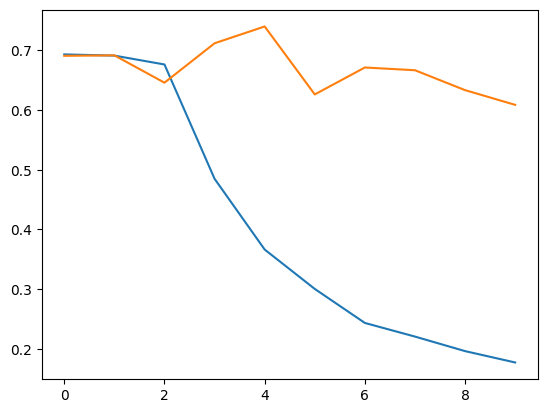

In [52]:
# Plot loss per iteration
plt.plot(rnn1.history['loss'], label='loss')
plt.plot(rnn1.history['val_loss'], label='val_loss')
plt.legend

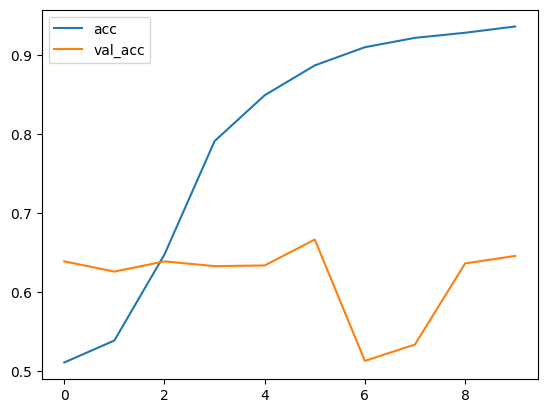

In [53]:
# Plot accuracy per iteration
plt.plot(rnn1.history['accuracy'], label='acc')
plt.plot(rnn1.history['val_accuracy'], label = 'val_acc')
plt.legend()

Next we will try a more complex LSTM RNN model.  The LSTM was changed to Bidirectional and an extra dense layer was added.

In [54]:
i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim = 512)(i)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model2 = Model(i, x)

In [55]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model2.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
rnn2 = model2.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 24s 370ms/step - loss: 0.6935 - accuracy: 0.4932 - val_loss: 0.6938 - val_accuracy: 0.3753
Epoch 2/10
47/47 [==============================] - 17s 364ms/step - loss: 0.6931 - accuracy: 0.5002 - val_loss: 0.6909 - val_accuracy: 0.6333
Epoch 3/10
47/47 [==============================] - 18s 383ms/step - loss: 0.6929 - accuracy: 0.5095 - val_loss: 0.6898 - val_accuracy: 0.6350
Epoch 4/10
47/47 [==============================] - 19s 398ms/step - loss: 0.6922 - accuracy: 0.5269 - val_loss: 0.6909 - val_accuracy: 0.6385
Epoch 5/10
47/47 [==============================] - 17s 364ms/step - loss: 0.6896 - accuracy: 0.5537 - val_loss: 0.6870 - val_accuracy: 0.6652
Epoch 6/10
47/47 [==============================] - 17s 351ms/step - loss: 0.6801 - accuracy: 0.6104 - val_loss: 0.6680 - val_accuracy: 0.6368
Epoch 7/10
47/47 [==============================] - 17s 354ms/step - loss: 0.5644 - accuracy: 0.7468 - val_loss: 0.6666 - va

So again we see some overfitting happening.

<function matplotlib.pyplot.legend(*args, **kwargs)>

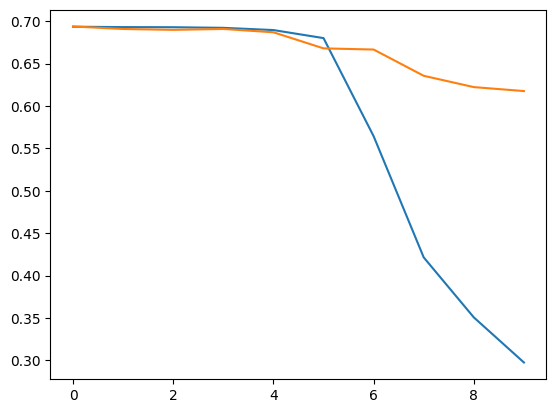

In [56]:
# Plot loss per iteration
plt.plot(rnn2.history['loss'], label='loss')
plt.plot(rnn2.history['val_loss'], label='val_loss')
plt.legend

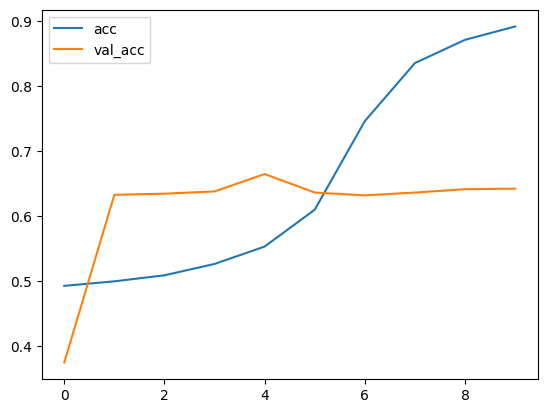

In [57]:
# Plot accuracy per iteration
plt.plot(rnn2.history['accuracy'], label='acc')
plt.plot(rnn2.history['val_accuracy'], label = 'val_acc')
plt.legend()

So for good measure lets try an even more complex model.  The output dimensions of the embedding layer were doubled to 1024 and an extra Dense layer was added.

In [58]:
i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim = 1024)(i)
x = SpatialDropout1D(0.3)(x)
x = Bidirectional(LSTM(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model3 = Model(i, x)

In [59]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model3.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
rnn3 = model3.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 25s 409ms/step - loss: 0.6940 - accuracy: 0.4966 - val_loss: 0.6918 - val_accuracy: 0.6324
Epoch 2/10
47/47 [==============================] - 17s 353ms/step - loss: 0.6938 - accuracy: 0.4961 - val_loss: 0.6922 - val_accuracy: 0.6324
Epoch 3/10
47/47 [==============================] - 17s 358ms/step - loss: 0.6934 - accuracy: 0.5044 - val_loss: 0.6928 - val_accuracy: 0.6652
Epoch 4/10
47/47 [==============================] - 16s 352ms/step - loss: 0.6937 - accuracy: 0.4953 - val_loss: 0.6928 - val_accuracy: 0.6264
Epoch 5/10
47/47 [==============================] - 17s 355ms/step - loss: 0.6932 - accuracy: 0.5090 - val_loss: 0.6927 - val_accuracy: 0.6808
Epoch 6/10
47/47 [==============================] - 18s 380ms/step - loss: 0.6928 - accuracy: 0.5168 - val_loss: 0.6907 - val_accuracy: 0.6488
Epoch 7/10
47/47 [==============================] - 17s 360ms/step - loss: 0.6923 - accuracy: 0.5202 - val_loss: 0.6879 - va

The training loss and validation loss decrease initially, indicating that the model is learning to fit the training data.

The training accuracy and validation accuracy increase, showing that the model's predictions are becoming more accurate on both the training and validation sets.

However, there's a gap between the training and validation performance, especially in the later epochs. This might suggest overfitting, where the model starts to memorize the training data and doesn't generalize well to new data.

The validation accuracy seems to be fluctuating without a clear trend, which could be due to the model's complexity or the lack of regularization.

<function matplotlib.pyplot.legend(*args, **kwargs)>

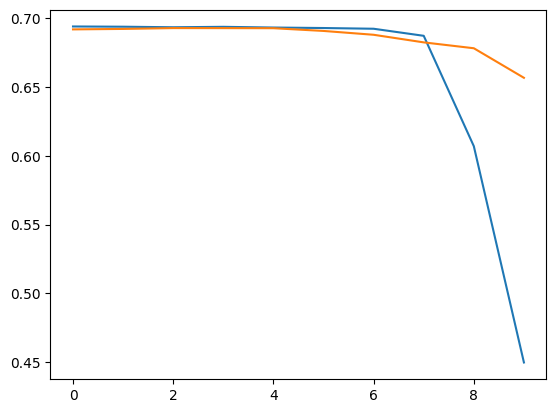

In [60]:
# Plot loss per iteration
plt.plot(rnn3.history['loss'], label='loss')
plt.plot(rnn3.history['val_loss'], label='val_loss')
plt.legend

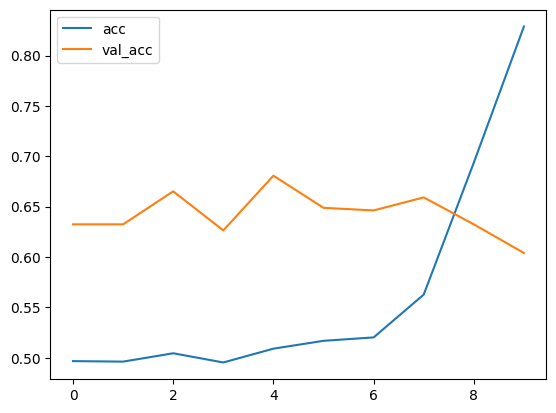

In [61]:
# Plot accuracy per iteration
plt.plot(rnn3.history['accuracy'], label='acc')
plt.plot(rnn3.history['val_accuracy'], label = 'val_acc')
plt.legend()

So next let's try a GRU instead of a LSTM.

In [62]:

i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim=512)(i)
x = SpatialDropout1D(0.3)(x)
x = GRU(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(x)  # Replace LSTM with GRU
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model4 = Model(i, x)

In [63]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model4.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
gru1 = model4.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 10s 146ms/step - loss: 0.6927 - accuracy: 0.5139 - val_loss: 0.6911 - val_accuracy: 0.6273
Epoch 2/10
47/47 [==============================] - 9s 186ms/step - loss: 0.6910 - accuracy: 0.5359 - val_loss: 0.6873 - val_accuracy: 0.6825
Epoch 3/10
47/47 [==============================] - 6s 137ms/step - loss: 0.6882 - accuracy: 0.5786 - val_loss: 0.6831 - val_accuracy: 0.6903
Epoch 4/10
47/47 [==============================] - 9s 185ms/step - loss: 0.6816 - accuracy: 0.6245 - val_loss: 0.6709 - val_accuracy: 0.7066
Epoch 5/10
47/47 [==============================] - 7s 141ms/step - loss: 0.6614 - accuracy: 0.7026 - val_loss: 0.6377 - val_accuracy: 0.7118
Epoch 6/10
47/47 [==============================] - 8s 171ms/step - loss: 0.5888 - accuracy: 0.7553 - val_loss: 0.6388 - val_accuracy: 0.6437
Epoch 7/10
47/47 [==============================] - 8s 179ms/step - loss: 0.4374 - accuracy: 0.8176 - val_loss: 0.6165 - val_accu

The training loss and validation loss decrease initially, indicating that the model is learning to fit the training data.

The training accuracy and validation accuracy increase, showing that the model's predictions are becoming more accurate on both the training and validation sets.

The validation accuracy is increasing over time, which is a positive sign.

There's less gap between the training and validation performance, suggesting that the model might be generalizing better and experiencing less overfitting compared to previous examples.

<function matplotlib.pyplot.legend(*args, **kwargs)>

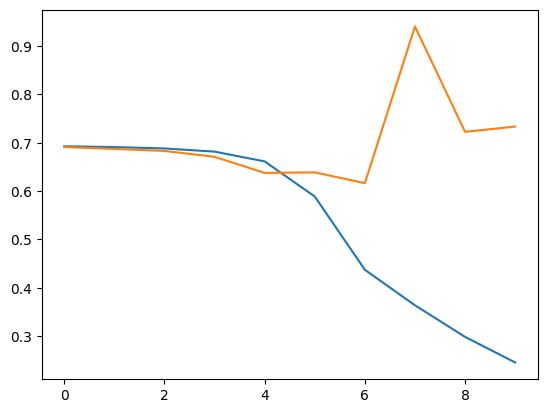

In [64]:
# Plot loss per iteration
plt.plot(gru1.history['loss'], label='loss')
plt.plot(gru1.history['val_loss'], label='val_loss')
plt.legend

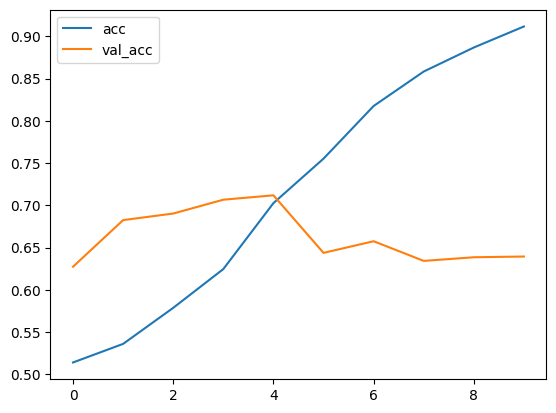

In [65]:
# Plot accuracy per iteration
plt.plot(gru1.history['accuracy'], label='acc')
plt.plot(gru1.history['val_accuracy'], label = 'val_acc')
plt.legend()

Trying a more complex GRU.

In [66]:
i = Input(shape=(padded_train.shape[1],))


x = Embedding(total_words + 1, output_dim=512)(i)
x = SpatialDropout1D(0.3)(x)
x = GRU(512, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)(x)
x = SpatialDropout1D(0.3)(x)
x = GRU(256, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(2, activation='sigmoid')(x)

# Create the model
model5 = Model(i, x)

In [67]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model5.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
gru2 = model5.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 24s 370ms/step - loss: 0.6930 - accuracy: 0.5103 - val_loss: 0.6922 - val_accuracy: 0.6333
Epoch 2/10
47/47 [==============================] - 14s 302ms/step - loss: 0.6930 - accuracy: 0.5076 - val_loss: 0.6916 - val_accuracy: 0.6506
Epoch 3/10
47/47 [==============================] - 14s 308ms/step - loss: 0.6925 - accuracy: 0.5229 - val_loss: 0.6895 - val_accuracy: 0.6721
Epoch 4/10
47/47 [==============================] - 14s 305ms/step - loss: 0.6860 - accuracy: 0.5998 - val_loss: 0.6784 - val_accuracy: 0.6557
Epoch 5/10
47/47 [==============================] - 14s 308ms/step - loss: 0.5910 - accuracy: 0.7190 - val_loss: 0.6449 - val_accuracy: 0.6471
Epoch 6/10
47/47 [==============================] - 14s 306ms/step - loss: 0.4212 - accuracy: 0.8183 - val_loss: 0.6989 - val_accuracy: 0.6359
Epoch 7/10
47/47 [==============================] - 15s 311ms/step - loss: 0.3440 - accuracy: 0.8589 - val_loss: 0.6373 - va

The training loss and validation loss decrease initially, indicating that the model is learning to fit the training data.

The training accuracy and validation accuracy increase, showing that the model's predictions are becoming more accurate on both the training and validation sets.

The validation accuracy seems to fluctuate slightly, which could indicate that the model's performance is not consistently improving on the validation set.

The model might have a tendency to overfit, as evidenced by the gap between the training accuracy and validation accuracy, especially in the later epochs.

<function matplotlib.pyplot.legend(*args, **kwargs)>

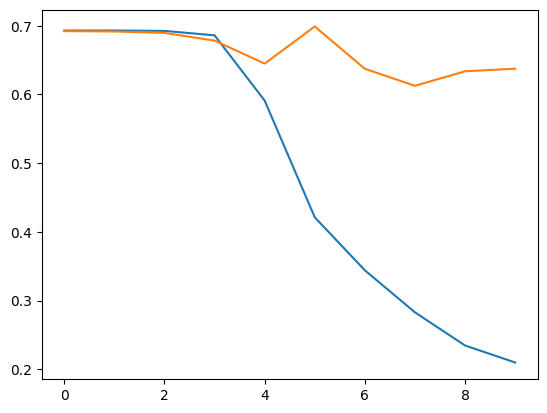

In [68]:
# Plot loss per iteration
plt.plot(gru2.history['loss'], label='loss')
plt.plot(gru2.history['val_loss'], label='val_loss')
plt.legend

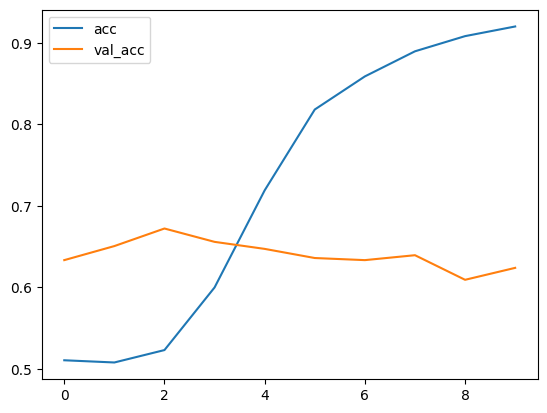

In [69]:
# Plot accuracy per iteration
plt.plot(gru2.history['accuracy'], label='acc')
plt.plot(gru2.history['val_accuracy'], label = 'val_acc')
plt.legend()

Let's now try a CNN.

In [70]:
i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim=512)(i)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model6 = Model(i, x)

In [71]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model6.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
cnn1 = model6.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 8s 13ms/step - loss: 0.6928 - accuracy: 0.5137 - val_loss: 0.6913 - val_accuracy: 0.6169
Epoch 2/10
47/47 [==============================] - 0s 8ms/step - loss: 0.6878 - accuracy: 0.5769 - val_loss: 0.6922 - val_accuracy: 0.5022
Epoch 3/10
47/47 [==============================] - 0s 7ms/step - loss: 0.6774 - accuracy: 0.6494 - val_loss: 0.6869 - val_accuracy: 0.6048
Epoch 4/10
47/47 [==============================] - 0s 7ms/step - loss: 0.6509 - accuracy: 0.7282 - val_loss: 0.6676 - val_accuracy: 0.7041
Epoch 5/10
47/47 [==============================] - 0s 7ms/step - loss: 0.5891 - accuracy: 0.8039 - val_loss: 0.6234 - val_accuracy: 0.7386
Epoch 6/10
47/47 [==============================] - 0s 8ms/step - loss: 0.4757 - accuracy: 0.8681 - val_loss: 0.5496 - val_accuracy: 0.7515
Epoch 7/10
47/47 [==============================] - 0s 7ms/step - loss: 0.3456 - accuracy: 0.9119 - val_loss: 0.5051 - val_accuracy: 0.7619
E

The training loss and validation loss decrease, indicating that the model is learning to fit the training data.

The training accuracy and validation accuracy increase, showing that the model's predictions are becoming more accurate on both the training and validation sets.

The validation accuracy is reasonably high and consistently increasing, indicating that the model is performing well on unseen validation data.

The model might not be showing signs of overfitting, as the gap between the training accuracy and validation accuracy is relatively small.

The training and validation metrics are improving across epochs, suggesting that the model is effectively learning the underlying patterns in the data.

<function matplotlib.pyplot.legend(*args, **kwargs)>

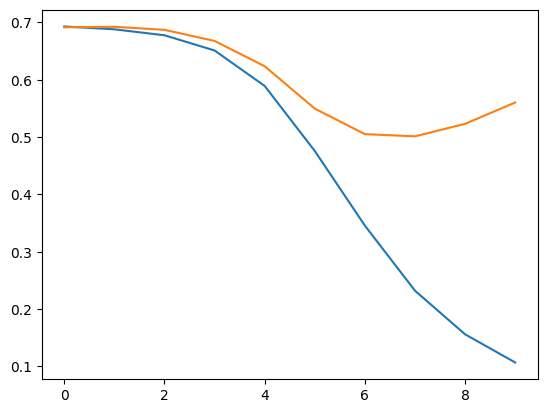

In [72]:
# Plot loss per iteration
plt.plot(cnn1.history['loss'], label='loss')
plt.plot(cnn1.history['val_loss'], label='val_loss')
plt.legend

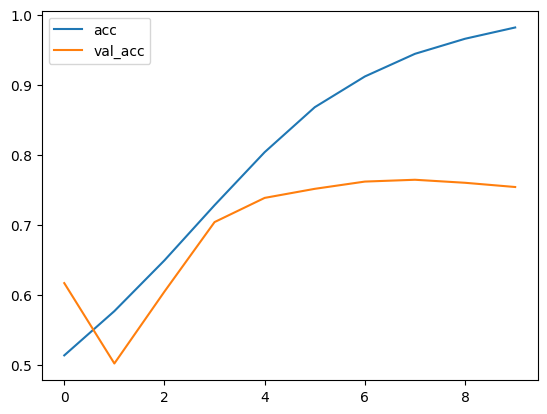

In [73]:
# Plot accuracy per iteration
plt.plot(cnn1.history['accuracy'], label='acc')
plt.plot(cnn1.history['val_accuracy'], label = 'val_acc')
plt.legend()

Now lets try a more complex CNN.

In [78]:
i = Input(shape=(padded_train.shape[1],))
x = Embedding(total_words + 1, output_dim=512)(i)
x = Conv1D(128, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(256, 5, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(512, 5, activation='relu', padding='same')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)

model7 = Model(i, x)

In [79]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model7.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
cnn2 = model7.fit(
    padded_train,
    y_train_cat,
    epochs=10,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/10
47/47 [==============================] - 2s 23ms/step - loss: 0.6931 - accuracy: 0.5095 - val_loss: 0.6948 - val_accuracy: 0.3960
Epoch 2/10
47/47 [==============================] - 1s 12ms/step - loss: 0.6895 - accuracy: 0.5339 - val_loss: 0.6841 - val_accuracy: 0.6117
Epoch 3/10
47/47 [==============================] - 1s 12ms/step - loss: 0.5998 - accuracy: 0.6994 - val_loss: 0.7068 - val_accuracy: 0.6462
Epoch 4/10
47/47 [==============================] - 1s 12ms/step - loss: 0.3106 - accuracy: 0.8801 - val_loss: 0.8083 - val_accuracy: 0.6566
Epoch 5/10
47/47 [==============================] - 1s 12ms/step - loss: 0.1303 - accuracy: 0.9529 - val_loss: 0.6723 - val_accuracy: 0.5168
Epoch 6/10
47/47 [==============================] - 1s 13ms/step - loss: 0.0579 - accuracy: 0.9841 - val_loss: 0.8303 - val_accuracy: 0.6713
Epoch 7/10
47/47 [==============================] - 0s 10ms/step - loss: 0.0253 - accuracy: 0.9934 - val_loss: 0.9704 - val_accuracy: 0.

Epoch 1: The training and validation accuracy are relatively low, indicating that the model's initial predictions are not very accurate. The validation accuracy is even lower, which suggests that the model may not be performing well on unseen data.

Epoch 2: Both training and validation accuracy increase, but the validation accuracy is still not very high. This could indicate that the model is starting to learn the data's patterns, but it's not yet performing well on unseen data.

Epoch 3: The validation accuracy increases further, suggesting that the model is improving. However, the training accuracy is much higher than the validation accuracy, indicating potential overfitting.

Epoch 4: Both training and validation accuracy show a significant gap, which could be a sign of overfitting. The model is performing well on the training data but doesn't generalize well to the validation data.

Epoch 5 to 10: The validation accuracy remains relatively stable, not showing significant improvements. The training accuracy continues to improve, which might indicate that the model is learning the training data very well but is struggling to generalize.

Overall, this training progress might indicate that the model is overfitting to the training data, as indicated by the large gap between training and validation accuracy. The model's performance on the validation data is not improving significantly after the initial few epochs, suggesting that it's not generalizing well to unseen data

<function matplotlib.pyplot.legend(*args, **kwargs)>

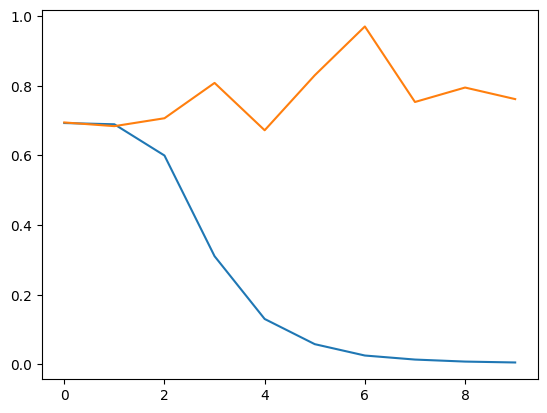

In [80]:
# Plot loss per iteration
plt.plot(cnn2.history['loss'], label='loss')
plt.plot(cnn2.history['val_loss'], label='val_loss')
plt.legend

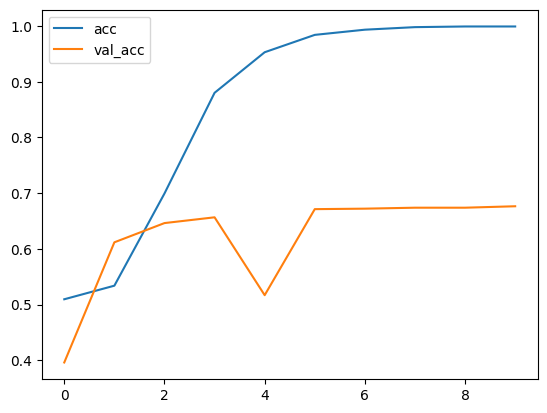

In [81]:
# Plot accuracy per iteration
plt.plot(cnn2.history['accuracy'], label='acc')
plt.plot(cnn2.history['val_accuracy'], label = 'val_acc')
plt.legend()

Now let's try something a bit crazy and combine a LSTM and CNN

In [102]:
i = Input(shape=(padded_train.shape[1],))

# Embedding layer
x = Embedding(total_words + 1, output_dim=512)(i)

# LSTM branch
lstm_branch = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))(x)

# Apply GlobalMaxPooling1D to LSTM branch
lstm_pooled = GlobalMaxPooling1D()(lstm_branch)

# Convolutional branch
conv_branch = Conv1D(filters=128, kernel_size=3, activation='relu')(x)
conv_branch = MaxPooling1D(pool_size=2)(conv_branch)
conv_branch = GlobalMaxPooling1D()(conv_branch)

# Concatenate LSTM and Convolutional branches
merged = concatenate([lstm_pooled, conv_branch], axis=-1)

# Dense layers
x = Dense(256, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)

# Output layer
x = Dense(2, activation='softmax')(x)

model8 = Model(i, x)

In [103]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

model8.compile(
    loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)


print('Training model...')
lstm_cnn = model8.fit(
    padded_train,
    y_train_cat,
    epochs=20,
    batch_size=128,
    validation_data=(padded_test, y_test_cat)
)

Training model...
Epoch 1/20
47/47 [==============================] - 25s 408ms/step - loss: 0.6919 - accuracy: 0.5241 - val_loss: 0.6850 - val_accuracy: 0.6342
Epoch 2/20
47/47 [==============================] - 19s 403ms/step - loss: 0.6797 - accuracy: 0.6621 - val_loss: 0.6670 - val_accuracy: 0.7023
Epoch 3/20
47/47 [==============================] - 17s 356ms/step - loss: 0.6083 - accuracy: 0.7639 - val_loss: 0.5775 - val_accuracy: 0.7291
Epoch 4/20
47/47 [==============================] - 17s 360ms/step - loss: 0.3540 - accuracy: 0.8560 - val_loss: 0.5460 - val_accuracy: 0.7041
Epoch 5/20
47/47 [==============================] - 18s 375ms/step - loss: 0.2048 - accuracy: 0.9267 - val_loss: 0.6453 - val_accuracy: 0.5867
Epoch 6/20
47/47 [==============================] - 18s 376ms/step - loss: 0.1422 - accuracy: 0.9524 - val_loss: 0.5175 - val_accuracy: 0.7541
Epoch 7/20
47/47 [==============================] - 17s 357ms/step - loss: 0.0992 - accuracy: 0.9673 - val_loss: 1.2566 - va

Epoch 1: The initial validation accuracy is relatively low, and the validation loss is quite high. This suggests that the model's initial predictions are not very accurate.

Epoch 2: Both training and validation accuracy increase, but the validation accuracy is still relatively low. The validation loss improves, indicating that the model is starting to learn the data's patterns.

Epoch 3: Both training and validation accuracy continue to increase. The validation loss decreases further, indicating that the model is improving.

Epoch 4: The model's performance continues to improve, with higher training and validation accuracy and lower validation loss.

Epoch 5 to 20: The validation accuracy continues to show improvement, although there are fluctuations. The validation loss also fluctuates but remains relatively low, suggesting that the model is learning and generalizing well.

Overall, this training progress is more positive than some of the previous ones. The validation accuracy is increasing, and the validation loss is decreasing, indicating that the model is learning and improving its performance on unseen data. However, there might still be some fluctuations, suggesting that fine-tuning the training process or trying different regularization techniques could potentially lead to even better performance.

<function matplotlib.pyplot.legend(*args, **kwargs)>

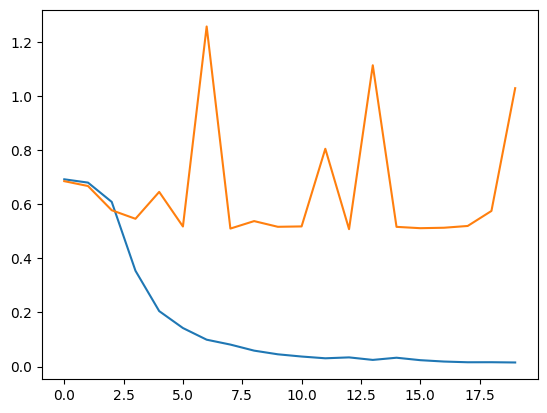

In [105]:
# Plot loss per iteration
plt.plot(lstm_cnn.history['loss'], label='loss')
plt.plot(lstm_cnn.history['val_loss'], label='val_loss')
plt.legend

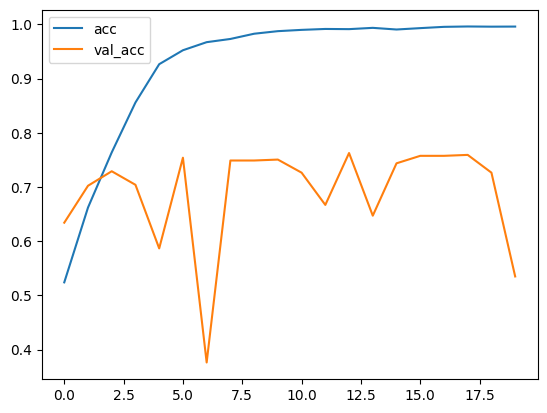

In [106]:
# Plot accuracy per iteration
plt.plot(lstm_cnn.history['accuracy'], label='acc')
plt.plot(lstm_cnn.history['val_accuracy'], label = 'val_acc')
plt.legend()

So the simple CNN and the combined LSTM-CNN models perform the best.  So lets see if we can fine tune them with a grid search.

## Hyperparameter Tuning

Simple CNN model hyperparameter tuning

In [108]:
# Define a function that creates the model
def create_model(optimizer='adam'):
    i = Input(shape=(padded_train.shape[1],))
    x = Embedding(total_words + 1, output_dim=512)(i)
    x = Conv1D(128, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(2, activation='sigmoid')(x)

    model = Model(i, x)

    optimizer = optimizer
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=128, verbose=0)

# Define the hyperparameter grid
param_grid = {
    'optimizer': ['adam', 'rmsprop'],
    'batch_size': [64, 128],
    'epochs': [10, 20]
}

# Create GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

# Fit the grid search
grid_result = grid.fit(padded_train, y_train_cat)

# Print the best results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-108-3b44f8616ec6>:25: DeprecationWarning:

KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.



Best: 0.847561 using {'batch_size': 64, 'epochs': 10, 'optimizer': 'rmsprop'}


## Analysis

So lets take a closer look at how the CNN model performed.

In [114]:
# make prediction
pred = model6.predict(padded_test)

37/37 [==============================] - 1s 3ms/step


In [115]:
# make prediction
prediction = []
for i in pred:
  prediction.append(np.argmax(i))

In [116]:
# list containing original values
original = []
for i in y_test_cat:
  original.append(np.argmax(i))

The model showed an accuracy of ~75.4% on unseen data.  This is decent but I was a litle disappointed I didn't get a model that achieved an accuracy 90% or better.  Perhaps with some changes to the model archietecture and more hyperparameter tuning it could be achieved.

In [117]:
# acuracy score on text data
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, prediction)
accuracy

0.7540983606557377

Looking at the confusion matrix shows that the model predicted positve sentiment tweets more accurately then the negative sentiment tweets.  

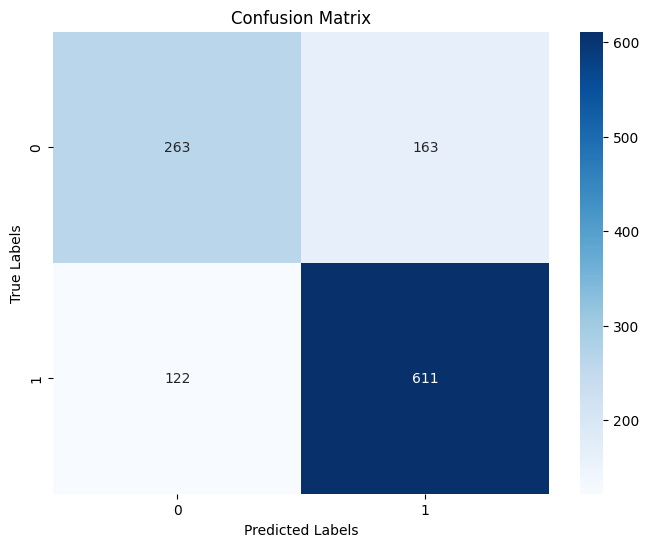

In [119]:
# Plot the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(original, prediction)

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

An AUC value of 0.73 indicates that the model is able to achieve a relatively good level of discrimination between the positive and negative classes. It means that, on average, the model's True Positive Rate (Sensitivity) is higher than that of a random classifier for a wide range of False Positive Rates (1 - Specificity).

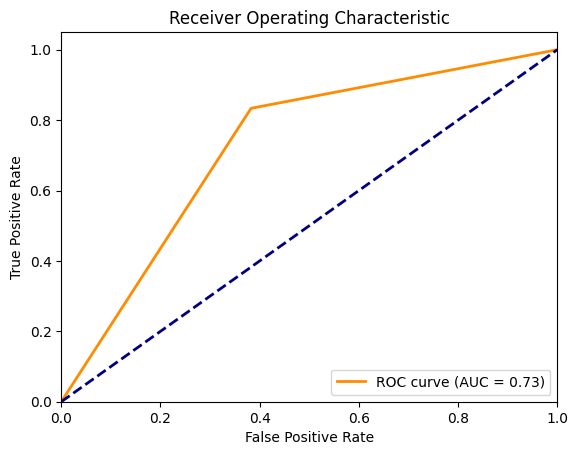

In [122]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(original, prediction)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

With the precision-recall curve we can see how the model handles the trade-off between precision and recall.  The bend at about (0.8, 0.8) suggests the model is starting to identify more positive instances, but some of them might be false positives. In other words, the model is becoming more liberal in its predictions, capturing more true positives but also making some incorrect positive predictions.

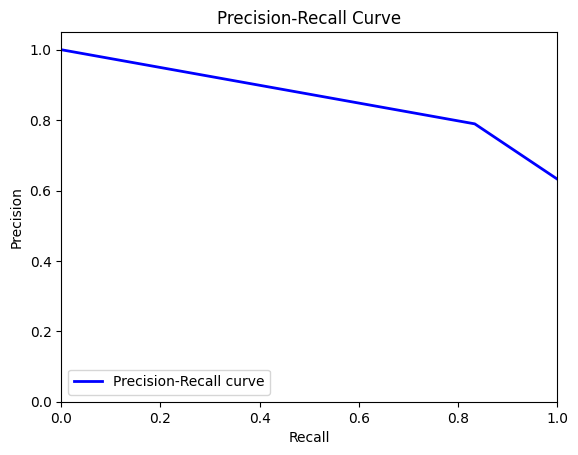

In [126]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(original, prediction)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [123]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(original, prediction)

print("Cohen's Kappa:", kappa)

Cohen's Kappa: 0.46020698479725597


A Cohen's Kappa value of 0.46 indicates a moderate level of agreement between the predicted labels and the true labels, beyond what could be expected by chance alone. Here's a rough guideline to interpret Cohen's Kappa values:

* Less than 0: Poor agreement
* 0 - 0.20: Slight agreement
* 0.21 - 0.40: Fair agreement
* 0.41 - 0.60: Moderate agreement
* 0.61 - 0.80: Substantial agreement
* 0.81 - 1.0: Almost perfect agreement

In [125]:
from sklearn.metrics import matthews_corrcoef
# Calculate Matthews Correlation Coefficient
mcc = matthews_corrcoef(original, prediction)

print("Matthews Correlation Coefficient:", mcc)

Matthews Correlation Coefficient: 0.4616008646472448


A Matthews Correlation Coefficient (MCC) value of 0.4616 indicates a moderately positive correlation between the predicted labels and the true labels. The MCC ranges from -1 to +1, where:

* +1: Perfect prediction
* 0: Random prediction
* -1: Inverse prediction

## Conclusion

I was a bit surprised when the simple CNN performed the best.  I would have wagered on one of the LSTM models or even the LSTM-CNN model at the beginning.  The LSTM-CNN model shows promise though.  With the numerous different architectures that could be build using a combination of LSTM and CNN layers there is very possibly a model that could achieve high accuracy with that dataset.  I would have loved to have tried more architectures and run hyperparameter tuning on them but I could only devote so much time to this project.

In the grander scheme of what this project is trying to accomplish, which is to make money in the stock market, one of these models could play a part.  A NLP model to detect sentiment of tweets could very well go into a more complex model's pipeline.

## References

Keras Natural Language Processing. (2023).  Code examples / Natural Language Processing.  https://keras.io/examples/nlp/

Lazy Programmer. (2023). Deep Learning: Convolutional Neural Networks in Python. https://www.udemy.com/course/deep-learning-convolutional-neural-networks-theano-tensorflow/

Lazy Programmer. (2023). Deep Learning: Recurrent Neural Networks in Python. https://www.udemy.com/course/deep-learning-recurrent-neural-networks-in-python/

 Dr. Ryan Ahmed, Ph.D, MBA, Michell Bouchard, Super Data Science Team, Ligency Team.  (2022). Python & Machine Learning for Financial Analysis. https://www.udemy.com/course/ml-and-python-in-finance-real-cases-and-practical-solutions/

